In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
!unzip -q 'gdrive/My Drive/road-signs-recognition.zip'

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
import torch
import pandas as pd
from skimage import io, transform
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from torchvision import transforms, utils, models
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()

In [ ]:
from tqdm import tqdm

In [ ]:
img_labels_df = pd.read_csv('train.csv')

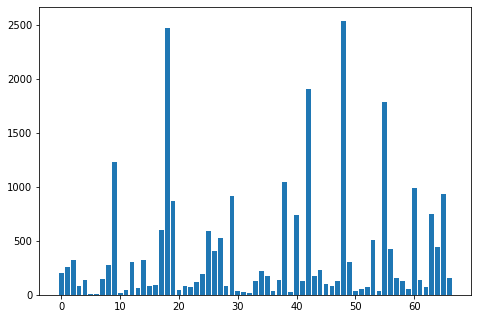

In [ ]:
counts = np.unique(img_labels_df['class_number'], return_counts=True)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(counts[0], counts[1])
plt.show()

In [ ]:
n = 10
img_name = img_labels_df.iloc[n, 0]
img_class = img_labels_df.iloc[n, 1]

print('Image name', img_name)
print('Image class', img_class)

Image name 000010.png
Image class 18


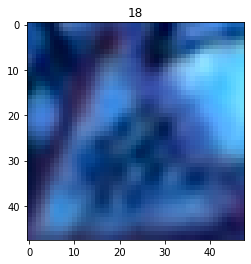

In [ ]:
def show_img_with_class(image, classes):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.title(classes)
    plt.pause(0.001)  # pause a bit so that plots are updated
plt.figure()
show_img_with_class(Image.open(os.path.join('train/train/', img_name)),
               img_class)
plt.show()

In [ ]:
class RoadSignsDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.img_classes_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_classes_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.img_classes_df.iloc[idx, 0])

        with open(img_name, 'rb') as f:
            image = Image.open(f)
            image = image.convert('RGB')

        img_classes = self.img_classes_df.iloc[idx, 1]
        img_classes = torch.tensor([img_classes])

        if self.transform:
            image = self.transform(image)
    
        sample = {'image': image, 'classes': img_classes}
        return sample

In [ ]:
signs_dataset = RoadSignsDataset(csv_file='train.csv',
                                    root_dir='train/train/')

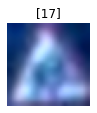

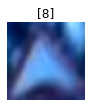

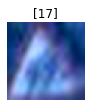

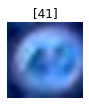

In [ ]:
fig = plt.figure()

for i in range(len(signs_dataset)):
    sample = signs_dataset[i + 5]
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.axis('off')
    show_img_with_class(**sample)
    if i == 3:
        plt.show()
        break

In [ ]:
transformed_dataset = RoadSignsDataset(csv_file='train.csv',
                                           root_dir='train/train/',
                                           transform=transforms.Compose([     
                                               transforms.ToTensor(),
                                               transforms.Normalize((0.3, 0.3, 0.3), ((0.3, 0.3, 0.3)))
                                           ]))

In [ ]:
batch_size = 128

In [ ]:
indices = list(range(len(transformed_dataset)))
train_indices, test_indices = train_test_split(
    indices,
    test_size=0.2,
    stratify=img_labels_df['class_number'])

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)


train_loader = torch.utils.data.DataLoader(transformed_dataset,
                                           batch_size=batch_size,
                                           sampler=train_sampler,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(transformed_dataset,
                                          batch_size=batch_size,
                                          sampler=test_sampler,
                                          num_workers=2)

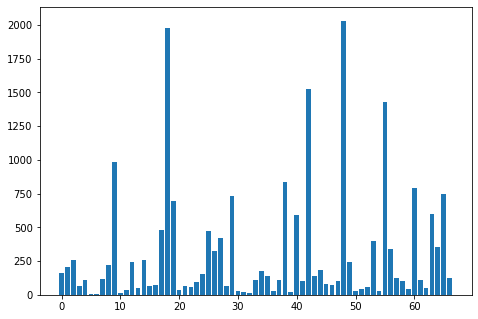

In [ ]:
a = []
for i, batch_dict in enumerate(train_loader):
    a = a + list(batch_dict['classes'])
counts = np.unique(a, return_counts=True)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(counts[0], counts[1])
plt.show()

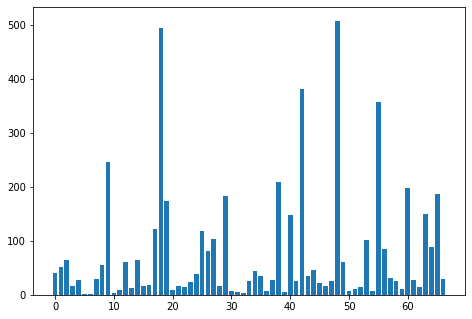

In [ ]:
a = []
for i, batch_dict in enumerate(test_loader):
    a = a + list(batch_dict['classes'])
counts = np.unique(a, return_counts=True)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(counts[0], counts[1])
plt.show()

In [ ]:
class train_test_net:
    def __init__(self, net, optimizer, batch_size, criterion, metric, device):
        self.net = net
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.criterion = criterion
        self.metric = metric
        self.device = device
    
    def train(self, train_loader, num_epochs=10, verbose=True, val_loader=None):
        for epoch in range(num_epochs):
            train_loss = 0.0
            train_acc = 0.0
            if val_loader:
                val_acc = 0.0
            self.net = self.net.train()

            loop = tqdm(enumerate(train_loader),
                        position=0,
                        leave=True,
                        mininterval=2)
            for i, data_dict in loop:

                images = data_dict['image'].to(self.device)
                labels = data_dict['classes'].to(self.device).view(-1)
                logits = self.net(images)
                loss = self.criterion(logits, labels)
                self.optimizer.zero_grad()
                loss.backward()

                self.optimizer.step()
                if verbose:
                    train_loss += loss.detach().item()
                    train_acc += self.metric(logits, labels)
                    loop.set_description(
                                        'Epoch {}/{} Loss:{} Metric:{}'.format(
                                             epoch + 1,
                                             num_epochs,
                                             loss.detach().item(),
                                             self.metric(logits,
                                                         labels))
                                        )
            num_batches_train = i
            self.net.eval()
            
            if val_loader:
                for i, data_dict in enumerate(val_loader):

                    val_images = data_dict['image'].to(self.device)
                    val_labels = data_dict['classes'].to(self.device).view(-1)
                    val_logits = self.net(val_images)
                    val_acc += self.metric(val_logits, 
                                           val_labels)
                num_val_batches = i

            if verbose:
                if val_loader:
                    print("Epoch: %d | Loss: %.4f | "
                          %(epoch + 1, train_loss / (num_batches_train + 1)) + \
                          "Train Accuracy: %.2f | Validation accuracy %.2f" \
                          %(train_acc / (num_batches_train + 1),
                            val_acc / (num_val_batches + 1))
                          )
                else:
                    print("Epoch: %d | Loss: %.4f | "
                          %(epoch + 1, train_loss / (num_batches_train + 1)) + \
                          "Train Accuracy: %.2f" \
                          %(train_acc / (num_batches_train + 1))
                          )

    def predict(predict_loader):
        answer = []
        for i, data_dict in enumerate(predict_loader):
            images = data_dict['image'].to(self.device)
            answer = answer + list(torch.argmax(self.net(images), dim=1))
        return answer

In [ ]:
def get_accuracy(predict, target):
    corrects = (torch.argmax(predict, dim=1) == target)
    accuracy = 100.0 * corrects.sum() / len(target)
    return accuracy.item()

In [ ]:
resnet18 = models.resnet18(pretrained=False)
resnet18.conv1 = torch.nn.Conv2d(3, 64, (1, 1))
resnet18.bn1 = torch.nn.Identity()
resnet18.relu = torch.nn.ReLU(inplace=True)
resnet18.maxpool = torch.nn.Identity()
resnet18.fc = torch.nn.Linear(512, 67)

In [ ]:
device = torch.device(
            "cuda:0" if torch.cuda.is_available() else "cpu")

resnet18.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.0008)

In [ ]:
train_test_model = train_test_net(
    resnet18,
    optimizer,
    batch_size,
    criterion,
    get_accuracy,
    device)

In [ ]:
train_test_model.train(train_loader, num_epochs=4, val_loader=test_loader)

Epoch 1/4 Loss:0.33459359407424927 Metric:94.21487426757812: : 159it [00:31,  5.11it/s]


Epoch: 1 | Loss: 1.0476 | Train Accuracy: 73.53 | Validation accuracy 83.19


Epoch 2/4 Loss:0.13938525319099426 Metric:97.52066040039062: : 159it [00:30,  5.14it/s]


Epoch: 2 | Loss: 0.1842 | Train Accuracy: 95.34 | Validation accuracy 92.93


Epoch 3/4 Loss:0.04699286073446274 Metric:98.34710693359375: : 159it [00:30,  5.14it/s]


Epoch: 3 | Loss: 0.0817 | Train Accuracy: 97.87 | Validation accuracy 90.04


Epoch 4/4 Loss:0.021498123183846474 Metric:99.17354583740234: : 159it [00:31,  5.11it/s]


Epoch: 4 | Loss: 0.0457 | Train Accuracy: 98.82 | Validation accuracy 97.64


In [ ]:
def make_predict(model, folder, device, transform):
    rezult = {}
    tree = os.walk(folder)
    for filename in next(tree)[2]:
        img_name = os.path.join(folder,
                                filename)
        with open(img_name, 'rb') as f:
            image = Image.open(f)
            image = image.convert('RGB')
        pred = torch.argmax(
            model(
                transform(image).type(torch.FloatTensor).view(1,
                                                              3,
                                                              48,
                                                              48).to(
                                                                  device
                                                                  )
                )
            )
        rezult[filename] = int(pred)
    return rezult

In [ ]:
rezult = make_predict(resnet18, 'test/test', device, transform=transforms.Compose([
                                               transforms.ToTensor(),
                                               transforms.Normalize((0.3, 0.3, 0.3), ((0.3, 0.3, 0.3)))
                                           ]))

In [ ]:
rezult_df = pd.DataFrame.from_dict(rezult,
                       orient='index',
                       columns=['class_number'])

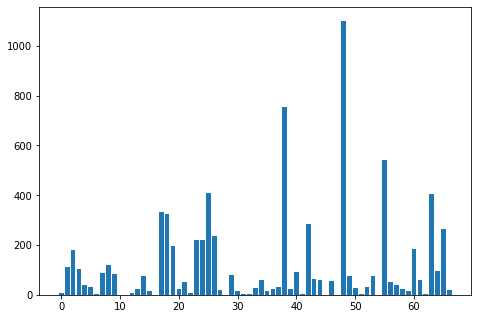

In [ ]:
counts = np.unique(rezult_df['class_number'], return_counts=True)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(counts[0], counts[1])
plt.show()

In [ ]:
rezult_df.index.name = 'filename'

In [ ]:
rezult_df.to_csv('rezult.csv', sep=',')